In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from pathlib import Path
from IPython.display import Image
import os

# as 5 decimal places are there in latitude and longitude
pd.options.display.float_format = "{:0.5f}".format

## 3. Taxi cab company wants to optimize for gross margin, profits, market share and CO2 emissions 💲💲🌳 
# - `Task3: Cluster taxis to gain insights`


# Answers from notebook 0. EDA
- We already saw `fraction of empty cabs throughout the day (every half hour)`
  - Taxi cab company can better estimate the demand and utilize these empty cabs for other purposes
- We also visualized `20 min. average location of empty and passenger-filled cabs` through a timeed heat map.
  - Generally, empty cabs are more spread out
    - Looking into Google maps, there is a `yellow taxi cab depot` nearby the red area, so it understandable.
    - During office hours, travel from far-away highways is more


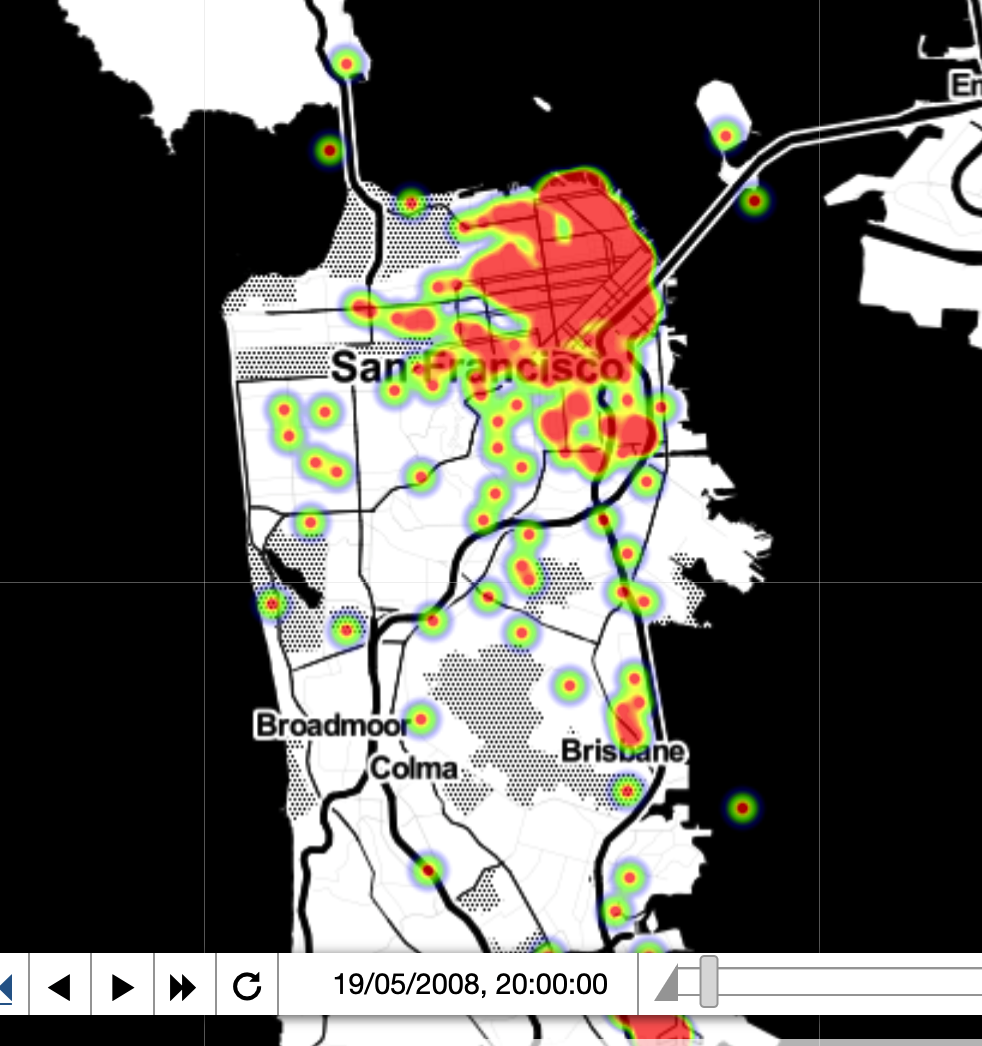

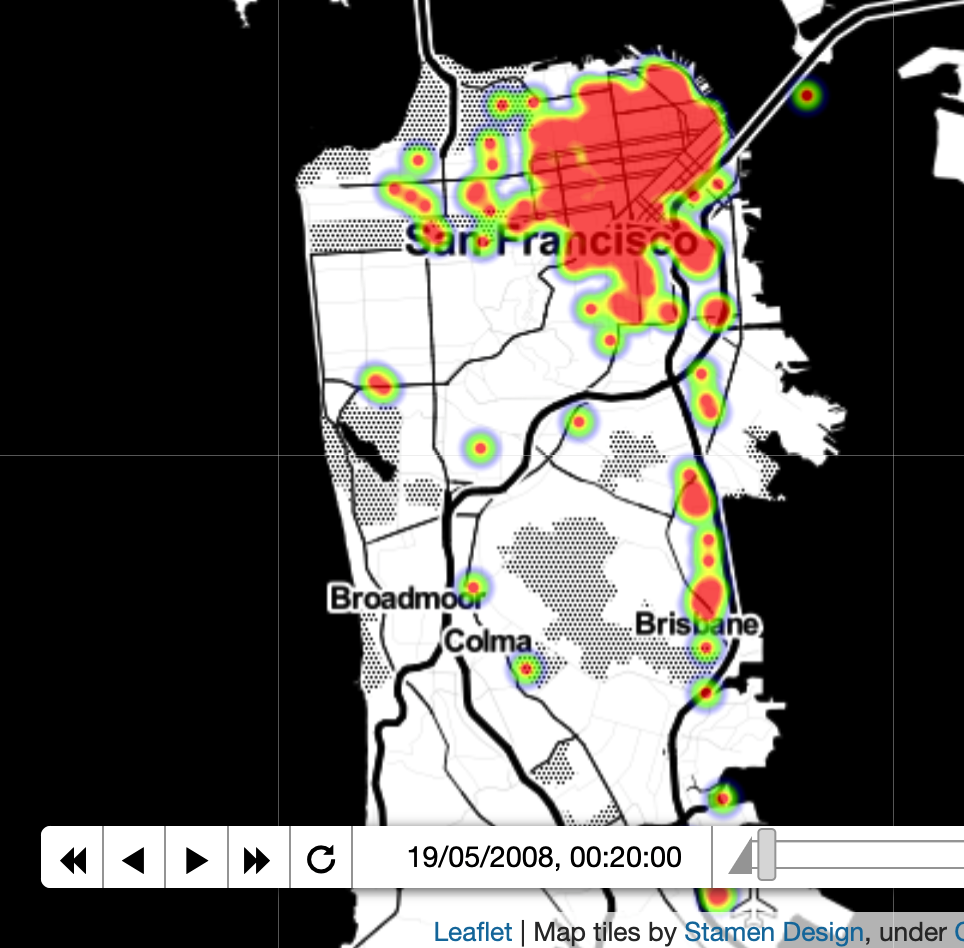

In [20]:
paths = ['../images/empty.png', '../images/filled.png']

from IPython.display import Image
from IPython.display import display
x = Image(filename=paths[0], width=300, height=300) # empty cabs cluster on a datetime 19/5 18:00
y = Image(filename=paths[1], width=300, height=300) # filled cabs cluster on same datetime
display(x, y)

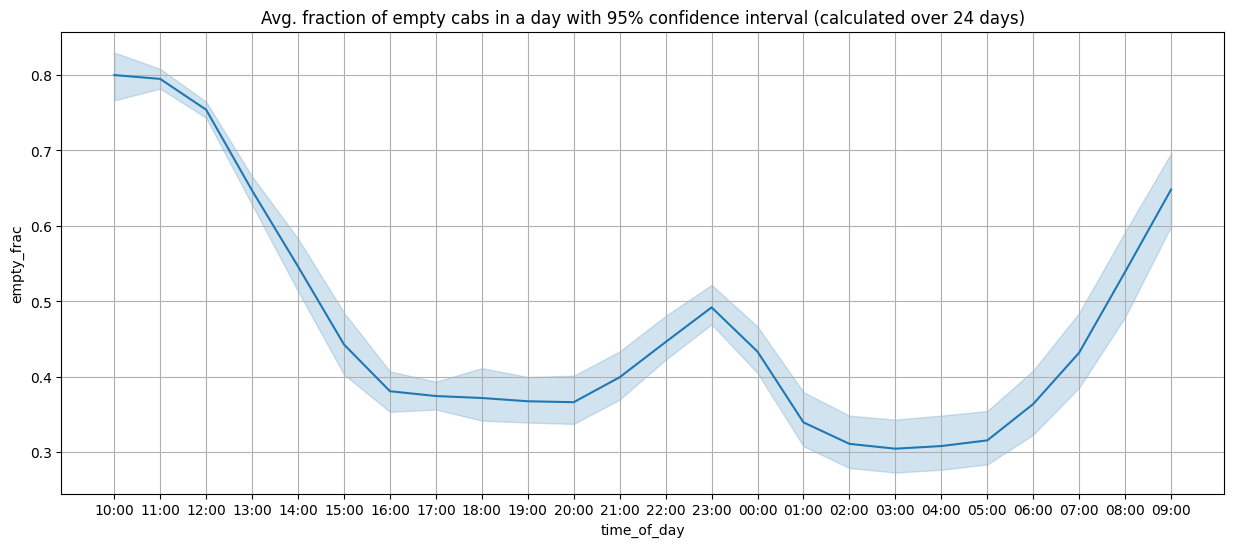

In [23]:
Image("../images/frac_empty_cabs.png", width=900, height=400)

# Clustering cabs in more ways

For a business it might be interesting to see:

1. Drivers that works a lot => more profit
     - Distance travelled with passengers can be a good indicator of this
2. Drivers that don't work much => can give them promotions or benefits to work more
     - Distance travelled with passengers
3. Driver efficiency
     - Dist. travelled with passengers/ Total Dist. travelled
4. Drivers that do go over speed limit (70mph) => This can impact cab company's reputation
     - unsafe for passenger -> liabilities

In [24]:
# load trips dataframe without outliers from notebook 01.
trips_df = pd.read_csv(
    "../data/processed_data/sf_cabs_trips_wo_outliers.csv",
    parse_dates=["trip_start_time", "trip_end_time"],
)
trips_df.cab_id = trips_df.cab_id.astype("category")
trips_df.occupancy = trips_df.occupancy.astype("category")
trips_df.head()

,cab_id,occupancy,haver_dist_miles,trip_start_lat,trip_end_lat,trip_start_lng,trip_end_lng,trip_start_time,trip_end_time,trip_duration,speed_miles_hr
0,new_adkavy,0,11.50841,37.79596,37.78705,-122.26824,-122.41098,2008-05-17 14:26:38,2008-05-17 15:52:58,0 days 01:26:20,7.99812
1,new_adkavy,1,13.40805,37.78726,37.61468,-122.41110,-122.38974,2008-05-17 15:53:13,2008-05-17 16:12:02,0 days 00:18:49,42.75376
2,new_adkavy,0,0.78039,37.61473,37.61656,-122.39468,-122.38590,2008-05-17 16:13:05,2008-05-17 16:59:08,0 days 00:46:03,1.01680
3,new_adkavy,1,13.51754,37.61464,37.78579,-122.39350,-122.42813,2008-05-17 17:44:27,2008-05-17 18:05:03,0 days 00:20:36,39.37148
4,new_adkavy,0,1.32891,37.78583,37.78632,-122.42816,-122.43902,2008-05-17 18:05:42,2008-05-17 18:13:24,0 days 00:07:42,10.35512


In [25]:
valuable_drivers = (
    trips_df.loc[trips_df.occupancy == 1]
    .groupby("cab_id", as_index=False)["haver_dist_miles"]
    .sum()
    .sort_values("haver_dist_miles", ascending=False)
)
valuable_drivers.head(10)

,cab_id,haver_dist_miles
2,new_abdremlu,4699.97284
204,new_epabcadu,4584.03961
219,new_etalrab,4452.00697
32,new_agvexpia,4354.30506
410,new_ojroigna,4213.35044
403,new_oivnabyo,4207.20352
497,new_ugatna,4115.25268
445,new_ophugbe,4045.97588
27,new_agdrea,4008.83494
414,new_okavkau,3999.00209


<AxesSubplot:ylabel='Count'>

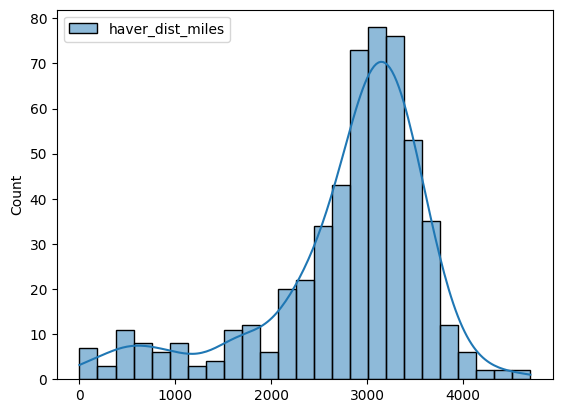

In [18]:
sns.histplot(valuable_drivers, kde=True)

### Business can cluster drivers according to profit they make based on above density graph


In [19]:
bottom_drivers = valuable_drivers.sort_values("haver_dist_miles")
bottom_drivers.head()

,cab_id,haver_dist_miles
160,new_egoiwroi,0.31826
201,new_eotcue,3.64277
356,new_mfeuer,9.08652
285,new_ifeshce,13.83582
1,new_abcoij,59.22886


## Efficiency of drivers

In [28]:
# efficiency of drivers
total_dist_df = trips_df.groupby("cab_id", as_index=False)["haver_dist_miles"].sum()
passenger_dist_df = (
    trips_df.loc[trips_df.occupancy == 1]
    .groupby("cab_id", as_index=False)["haver_dist_miles"]
    .sum()
)

df = pd.merge(total_dist_df, passenger_dist_df, on="cab_id")
df["efficiency"] = df.haver_dist_miles_y / df.haver_dist_miles_x
df.sort_values(by="efficiency", ascending=False)

,cab_id,haver_dist_miles_x,haver_dist_miles_y,efficiency
33,new_agyamker,4327.25521,3314.37567,0.76593
285,new_ifeshce,19.55622,13.83582,0.70749
399,new_oilrag,189.82622,128.45834,0.67672
526,new_utkibedy,4940.76383,3276.26933,0.66311
446,new_opjermp,4689.72138,3102.13774,0.66148
...,...,...,...,...
230,new_ewbglo,7092.91517,2993.71460,0.42207
203,new_eoydba,4328.67673,1815.11423,0.41932
517,new_upthin,5492.44787,2258.17485,0.41114
356,new_mfeuer,25.96723,9.08652,0.34992


<AxesSubplot:ylabel='Count'>

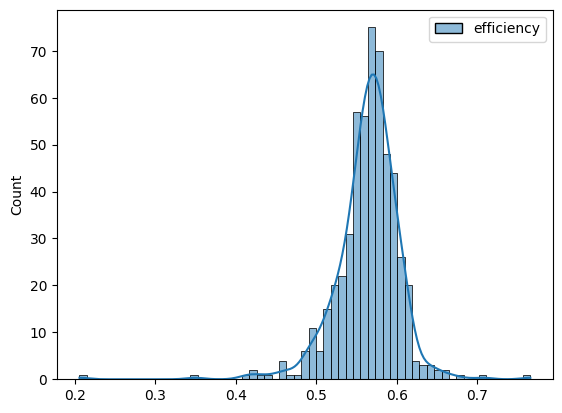

In [29]:
sns.histplot(df[["cab_id", "efficiency"]], kde=True)

### High performance drivers are rare ->on  the right 
### Most are good -> in the middle
Business can have a reward program for high performing drivers

## Liability Drivers

In [39]:
overspeeding_drivers = trips_df.loc[trips_df.speed_miles_hr > 70]
overspeeding_drivers = overspeeding_drivers[
    ["cab_id", "occupancy", "speed_miles_hr"]
].sort_values("speed_miles_hr", ascending=False)
max_speed_per_driver = overspeeding_drivers.groupby("cab_id", as_index=False)[
    "speed_miles_hr"
].max()

<AxesSubplot:ylabel='Count'>

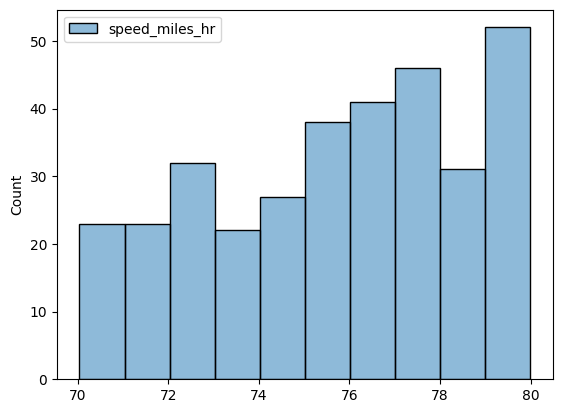

In [ ]:
sns.barplot(max_speed_per_driver)

In [42]:
overspeeding_drivers.head(10)

,cab_id,occupancy,speed_miles_hr
644080,new_uthiss,1,79.99401
423348,new_usadrifo,0,79.97743
21820,new_upthin,1,79.97702
655206,new_ubgihoot,1,79.97136
96207,new_owufrey,0,79.95674
59924,new_ankped,1,79.93917
195181,new_ejkipub,1,79.89855
433796,new_okavkau,1,79.89152
216488,new_esudcejo,1,79.88555
301747,new_ocshitcl,0,79.85979


## Other ideas

---

- root cause analysis of outliers in notebook 1.
  - tampering of sensors
  - gps errors etc.
  - gaming the system/ `fraud`

---

- It might be interesting to see the `passenger data` (passenger trails) alongside cab data
  - To effectively form relationships between `demand` and `supply`
  - To estimate data of competitors